In [1]:
# Import relevant packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
from collections import namedtuple, Counter
from os.path import exists
from tqdm import tqdm

## Heuristic 1
### Description

If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.

In [2]:
withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

### Function summary: addresses_to_transactions

Given a transactions DataFrame, returns a dictionary with the unique addresses of the transactions data as keys and a list of tuples as values. The tuples consist on the hash of the transaction with the address as the corresponding key in the first index, the timestamp of the transaction in the second index and the tornado cash pool that the address is interacting with in that specific transaction.

For example, if the address 0x6c6e4816ecfa4481472ff88 has made transaction with a hash 0x7f851ba1d7292ca565961073a111 that interacted with the 0.1 ETH pool at timestamp 1, and another transaction with hash 0x8f851ba1d7192ca565961073a9191 that interacted with the 1ETH pool at timestamp 2, then the dictionary returned will be:

```
{"0x6c6e4816ecfa4481472ff88": [("0x7f851ba1d7292ca565961073a111", timestamp1, "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc"), ("0x8f851ba1d7192ca565961073a9191", timestamp2, "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936")]
```

Note that "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936" is the 1 ETH address and "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc" the one of 0.1 ETH pool

In [3]:
withdraw_transactions_df

,Unnamed: 0,Unnamed: 0.1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,...,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
0,0,7,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb...,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,...,1,2020-10-05 07:57:28+00:00,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be9...,NaN,NaN,NaN,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
1,1,8,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da...,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,...,1,2020-02-11 19:10:54+00:00,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac06...,NaN,NaN,NaN,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
2,2,9,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f...,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,...,1,2020-02-16 16:05:14+00:00,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290...,NaN,NaN,NaN,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
3,3,13,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad1...,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,...,1,2020-11-09 17:08:00+00:00,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaee...,NaN,NaN,NaN,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
4,4,15,0x30becee80e63a039102df3b1243e5d314534abfcf3ed...,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,...,1,2020-11-29 01:18:57+00:00,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e...,NaN,NaN,NaN,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83777,83777,181253,0x5a36df89fa1f1ef6de7254e4b5fbfd2d6c2297ef4621...,164,188,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570447,70188284576,...,1,2021-09-05 01:23:28+00:00,13162729,0xe14fb1085bc975af1ad751aa579d7de298fb5be86c3d...,1.027888e+11,2.210156e+09,2.0,70188284576,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47
83778,83778,181255,0x43a081968e109f71a2f807f4a94ffc77429b322c3c1e...,169,168,0xe7a784acb145bd8993e83d41adf43b7c7195e995,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567923,39255417592,...,1,2021-10-03 14:49:29+00:00,13346858,0xe5a4d9c829998f00873f6ac4603174d707ffb2ea79a3...,4.000000e+10,1.130179e+09,2.0,39255417592,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xe7a784acb145bd8993e83d41adf43b7c7195e995
83779,83779,181262,0xd0708b3e2135d0378a9d6fe3fdc58b3c4fbcbcbe926c...,246,10,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567971,50193886615,...,1,2021-10-17 23:36:24+00:00,13438417,0x36808310975d158e0f2b3a2f892abed25a955684f407...,7.518635e+10,1.519911e+09,2.0,50193886615,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4
83780,83780,181263,0x54b5ceca9fd3d2ff7893c32f901f3d1d5e2e4383607b...,127,180,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570459,81048817558,...,1,2021-09-04 22:53:33+00:00,13162025,0x15a807c50ecea90cd58f5f9d6a26e0c60f3e9f06dfa6...,1.349098e+11,3.899014e+09,2.0,81048817558,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47


In [4]:
def addresses_to_transactions(transactions_df):
    
    # Initialize empty dictionary to store addresses and associated transactions.
    
    address_to_transactions_dict = {}
    
    # We iterate over every transaction in the transactions DataFrame.
    
    for row in tqdm(transactions_df.itertuples(), mininterval=5, total=transactions_df.shape[0]):
        '''
        We check if the address of the current transaction in the iteration is already in the 
        dictionary. If it isn't, then we initialize that key and the list with the tuple. The
        tuple will consist of the hash and the timestamp of the current transaction.
        
        If the key already exists, we append to the associated list the tuple of the hash and
        timestamp of the current transaction.
        '''
        
        if row.from_address not in set(address_to_transactions_dict.keys()):
            address_to_transactions_dict[row.from_address] = [(row.hash, row.block_timestamp, row.tornado_cash_address)]
        else:
            address_to_transactions_dict[row.from_address].append((row.hash, row.block_timestamp, row.tornado_cash_address))
    
    # The dictionary with the addresses and transactions is returned.
    
    return address_to_transactions_dict

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and a dictionary corresponding to what is returned by function addresses_to_transactions.

It returns a tuple:

* (True, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.

* (False, None): When no such deposit was found

In [5]:
def same_deposit_and_recipient_address_heuristic(withdraw_transaction, deposit_addresses_to_transactions):
    
    '''
    Check if the address of the withdraw tx is in the deposit_addresses_to_transactions keys.
    If it is, then a list is created with the hashes of all the deposit txs with the same address and
    with an earlier timestamp than the withdraw tx.
    If the address is not in the deposit_addresses_to_transactions dictionary, (False, None) is returned.
    '''
    
    if withdraw_transaction.recipient_address in set(deposit_addresses_to_transactions.keys()):
        
        # Only the transactions with earlier timestamps and same pool are selected for the list same_deposit_address_hashes.
        same_deposit_address_hashes = [tx_hash[0] for tx_hash in deposit_addresses_to_transactions[withdraw_transaction.recipient_address] if (tx_hash[1] <= withdraw_transaction.block_timestamp) and (tx_hash[2] == withdraw_transaction.tornado_cash_address)]
        
        # Final check to assert that list is not empty.
        if len(same_deposit_address_hashes) > 0:
            return (True, same_deposit_address_hashes)
        else:
            return (False, None)
        
    return (False, None)

In [6]:
# deposit_addresses_to_transactions = addresses_to_transactions(deposit_transactions_df)


### Function summary: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction. Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.


In [7]:
def apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df):
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    deposit_addresses_and_transactions = addresses_to_transactions(deposit_transactions_df)
    
    same_deposit_address_hashes = {}
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
    
    for withdraw_row_tuple in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=5):
        deposit_hashes = same_deposit_and_recipient_address_heuristic(withdraw_row_tuple, deposit_addresses_and_transactions)
        # print(deposit_hashes)

        if deposit_hashes[0]:
            same_deposit_address_hashes[withdraw_row_tuple.hash] = deposit_hashes[1]

    # Return the dictionary with the links
    
    return same_deposit_address_hashes

In [8]:
hashes_dict = apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df)

100%|██████████████████████████████████| 83782/83782 [02:19<00:00, 602.07it/s]


In [9]:
# Count of deposit transactions linked to withdraws.
linked_deposits_count = list(map(lambda x: len(x), hashes_dict.values()))

In [10]:
len(linked_deposits_count)

14284

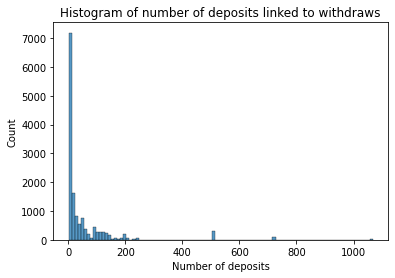

In [11]:
sns.histplot(data=linked_deposits_count, bins=100)
plt.title("Histogram of number of deposits linked to withdraws")
plt.xlabel("Number of deposits")
plt.show()

## Heuristic 2

### Description

If there is a deposit and a withdraw transaction with **unique** gas prices (e.g., 3.1415926 Gwei), then we consider the deposit and the withdraw transactions linked. The corresponding deposit transaction can be removed from any other withdraw transaction’s anonymity set.

### Getting the data
We obtain the data using Google Big Query.
In order to obtain the deposits and withdrawals transactions, just run the following querys:

### Withdrawals 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0x21a0adb6";

### Deposits
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0xb214faa5";

References here:
https://github.com/Phread420/tornado_bigquery/blob/main/Notes.md

This results are stored in the following files:
- withdraw_transactions.csv
- deposit_transactions.csv

After obtaining those two files, the next thing to do is to get the "recipient_addresses" that are making the withdrawl (if the user withdraws via a relayer, the relayer's account will be displayed in the "from_addres" field). That information is encoded in the "input" field of the withdrawal transactions.

The process to do so is in the following notebook:
https://github.com/lambdaclass/tornado_cash_anonymity_tool/blob/main/notebooks/complete_withdraw_data_set.ipynb

Note that the recipient addresses obtained in this df are in upper case and the addresses coming from the big query are in lower case, so you have to make the transformation when running the heuristic.

In [12]:
# Load transactions data

withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
# Change recipient_address to lowercase.
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
# Change block_timestamp field to be a timestamp object.
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

non_relayer_withdraw_transactions_df = withdraw_transactions_df[withdraw_transactions_df["from_address"]==withdraw_transactions_df["recipient_address"]]

deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
# Change block_timestamp field to be a timestamp object.
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

# tornado_addresses = pd.read_csv("../data/tornadocontracts_abi.csv", names=['address', 'contract_currency', 'value', '4'])

### Function summary: filter_by_unique_gas_price

Given a transactions DataFrame, it returns a dictionary with the unique gas prices as keys and a tuple containing the hash of that transaction and the timestamp. For example,

```
{111000302: ("0x387fcd87a", timestamp1)
```

In [13]:
def filter_by_unique_gas_price(transactions_df):
    
    # Count the appearances of each gas price in the transactions DataFrame.
    
    gas_prices_count = transactions_df["gas_price"].value_counts()
    
    # Filter the gas prices that are unique, i.e., the ones with a count equal to 1.
    # The gas prices are stored in unique_gas_prices
    
    unique_gas_prices = gas_prices_count[gas_prices_count == 1].keys()
    
    # A dataframe of the transactions that verify having these unique gas price values.
    
    temp_df = transactions_df[transactions_df["gas_price"].isin(unique_gas_prices)]
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return {row.gas_price: (row.hash, row.block_timestamp) for row in temp_df.itertuples()}

### Function summary: filter_by_unique_gas_price_by_pool

Given a transactions DataFrame, it returns a dictionary with a tuple of the unique gas prices and tornado pool as keys and a tuple containing the hash of that transaction and the timestamp. For example, 

```
{(111000302, "0x24387248"): ("0x387fcd87a", timestamp1)

```

In [14]:
def filter_by_unique_gas_price_by_pool(transactions_df):
    
    # Count the appearances of each gas price by pool in the transactions DataFrame.
    
    gas_prices_count = deposit_transactions_df[["gas_price", "tornado_cash_address"]].value_counts()
    
    '''
    Filter the gas prices that are unique for each pool, i.e., the ones with a count equal to 1.
    The gas prices are stored in unique_gas_prices
    '''
    
    unique_gas_prices_by_pool = pd.DataFrame(gas_prices_count[gas_prices_count == 1])
    
    # Tuple set with the values (gas_price, tornado_cash_address) is made to filter efficiently
    
    tuple_set = set([(row.Index[0], row.Index[1]) for row in unique_gas_prices_by_pool.itertuples()])
    
    # A dataframe of the transactions that verify having these unique gas price values by pool.
    
    temp_df = pd.DataFrame(filter(lambda iter_tuple: (iter_tuple.gas_price, iter_tuple.tornado_cash_address) in tuple_set, deposit_transactions_df.itertuples()))
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return {(row.gas_price, row.tornado_cash_address): (row.hash, row.block_timestamp) for row in temp_df.itertuples()}

A test of the function applied to our deposit transactions data.

### Function summary: same_gas_price_heuristic

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits, as returned by the function filter_by_unique_gas_price.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [15]:
def same_gas_price_heuristic(withdrawal_transaction, unique_gas_price_deposit_dict):
    
    '''
    Check if the gas price of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    '''
    
    if withdrawal_transaction.gas_price in set(unique_gas_price_deposit_dict.keys()) and (unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][1] < withdrawal_transaction.block_timestamp):
        return (True, unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][0])
    else:   
        return (False, None)

### Function summary: same_gas_price_heuristic_by_pool

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits made in each pool, just as returned by the function filter_by_unique_gas_price_by_pool.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price and belonging from the same pool (for example, 1ETH) as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [16]:
def same_gas_price_heuristic_by_pool(withdrawal_transaction, unique_gas_price_deposit_dict):
    
    '''
    Check if the pair (gas_price, tornado_pool) of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    '''
    
    if (withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address) in set(unique_gas_price_deposit_dict.keys()) and (unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][1] < withdrawal_transaction.block_timestamp):
        return (True, unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][0])
    else:   
        return (False, None)

### Function summary: apply_same_gas_price_heuristic

Applies the heuristic to all the withdraw_transactions DataFrame. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [17]:
def apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df):
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = {}
    
    # Iterate over the withdraw transactions.
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=10):     
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[0]:
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[1]

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit

### Function summary: apply_same_gas_price_heuristic_by_pool

Applies the heuristic to all the withdraw_transactions DataFrame, filtering also by the particular pool. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [18]:
def apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, withdraw_transactions_df):
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price_by_pool(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = {}
    
    # Iterate over the withdraw transactions.
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=10):     
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic_by_pool(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[0]:
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[1]

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit

We run the heuristic for the entire withdraw dataset

In [19]:
linked_transactions = apply_same_gas_price_heuristic(deposit_transactions_df, non_relayer_withdraw_transactions_df)

100%|█████████████████████████████████| 17037/17037 [00:08<00:00, 2018.77it/s]


In [20]:
linked_transactions = pd.DataFrame.from_dict({"withdraw_hashes": linked_transactions.keys(), "deposit_hashes": linked_transactions.values()})
linked_transactions

,withdraw_hashes,deposit_hashes
0,0xb07d06c8ca80ce4052954393d79b2f95d83034607d15...,0xbcd359d0323dc74c7a246d98cae706c75a6b3b518203...
1,0xbace5d33d2ce99ea408a03924846f4f5bc47b5125be3...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
2,0x99b09453c62a24b9b7f78c27b37d1c06c2b9a6428541...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
3,0xa0b96bec4615aad1d3c79871316cadd13f0b632e95ad...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
4,0x02f760cf72499455028fd5f99ccb0d8d8b56a637c5d2...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
...,...,...
123,0x9668053f20bc95ef17dc427ef913883cefc0a639bbc2...,0x0360baaa220ad16d11edc64123f17dbdbc5547904d50...
124,0x73fd2f663dc86d8bb252726dc7cbf9af5ff6eb786a0e...,0xb61a3104f74c1af05c8b8742288da600cee5744ad4af...
125,0x155c67c52f442d8e311f8dcfeb802db1fe0539c8b624...,0xfde60cd9b4b53885ae6bdc1ac39b5760232634a595e7...
126,0x92af7fcb7e26b1fbaf166347f144f4ed2b536c3724e1...,0x79ae9cc02ab3a954ad50bcedce6761ab4d7ea4760361...


Now we run the heuristic that filters by pool, again applying it to the entire withdraw dataset.

In [21]:
linked_transactions_by_pool = apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, non_relayer_withdraw_transactions_df)

100%|█████████████████████████████████| 17037/17037 [00:10<00:00, 1668.22it/s]


In [22]:
linked_transactions_by_pool_df = pd.DataFrame.from_dict({"withdraw_hashes": linked_transactions_by_pool.keys(), "deposit_hashes": linked_transactions_by_pool.values()})
linked_transactions_by_pool_df

,withdraw_hashes,deposit_hashes
0,0xda1eb6593a724f270d6668932f874546a0e98317ff76...,0xd382985d27002cbd8c803b324a42dcc93e39955fb9a4...
1,0x67586876b52286e9b976ace3edd9b79c4e8a75b0e912...,0x195fd8c20dacb7bb4c6e4b68a440df384473052bc39e...
2,0x1135c0eded88540534712a824bda2b906a3f6d6106da...,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb...
3,0xc2ee3f975d14c5d1f57e2381414ea092df1eda2d0e2f...,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb...
4,0x039c04c3d40dc1e1ef9b1108905e5aeceb82e05a0d4e...,0xdeaa7d1eaf4cfeedbc4496e85c1f3cb7f7ca3471e2c1...
...,...,...
167,0x4611c3b8eb6b90d267295aa822878a4200e5257fa381...,0x1af19bf59b0a2c3877a784d7c0e9d879e0550236bb25...
168,0x88e3e2d091efaa07f3ca7bae94d7cd6314ca68127d6b...,0x773d0041752549dbffa735b3a5778746789adcdce51b...
169,0x2516a26c3ff0a0583c72b9b5666c36370789843ff85e...,0x658be4fc6bf021744611067c36319be83f49f011fa7a...
170,0x9e1a17c0286f15358687ae7cb4f206ccfa14a08b5384...,0x1cdf20fc3fcf4ef61a3e3e45e579611e1070a0de8771...


## Heuristic 3 - Transactions outside TCash

### Description
The main goal of this heuristic is to link Ethereum accounts which interacted with TCash by inspecting Ethereum transactions outside it. 

This is done constructing two sets, one corresponding to the unique TCash deposit addresses ($S_{D}$) and one to the unique TCash withdraw addresses ($S_{W}$), to then make a query to reveal transactions between addresses of each set.

Withdraw transactions are inspected one by one, searching for Ethereum transactions done between the withdraw address and any of the deposit addresses. When such a transaction is found, the withdraw transaction is linked with all the deposits of the deposit addresses that were done before the withdraw.


### Data
The query to the public BigQuery database was done like so,

```
INSERT `tornado_cash_transactions.transactions_between_withdraw_and_deposit_addresses` 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions`
WHERE 
    (
       (`from_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
       AND 
       (`to_address` IN ( SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
    )
    OR
    (
       (`from_address` IN (  SELECT `withdraw_address` FROM `tornado_cash_transactions.withdraw_addresses`))
       AND 
       (`to_address` IN ( SELECT `from_address` FROM `tornado_cash_transactions.deposit_addresses`))
    )
```

The resulting table has two columns, **from_address** and **to_address**, and each row corresponds to a transaction done between a TCash deposit address and a TCash withdraw address, outside TCash.
From this table, we want to know which of the two addresses was the one that made the deposit and which one made the withdraw. In this way, we are able to link the corresponding deposit and withdraw transactions.

For example, consider this entry from the resulting table,

| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |

Suppose that `address1` is an address that withdrawed in TCash and `address2` one that made a deposit. Then, we want to transform said entry to one with colums **deposit_address** and **withdraw_address** like so,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |

With this new table, it is straightforward to make de linking between TCash transactions. With it, we can create a mapping to know with what deposit addresses each withdraw address interacted with.


### Some definitions 
A problem raises when there are addresses that belong to the two sets of TCash addresses $S_{D}$ and $S_{W}$.
Let us define an address of type `D` when it belongs to $S_{D}$ and not to $S_{W}$.
Likewise, an address of type `W` is defined when it belongs to $S_{W}$ and not to $S_{D}$. 
Finally, when an address belongs to both sets, we classify it as a `DW` type.

For the cases where we got outside TCash transactions of type `D -> W` (i.e., a transaction from a *D* type address to a *W* type address) or `W -> D` (i.e., a transaction from a *W* type address to a *D* type address), it is trivial to transform this entry to the new table.

In the cases where we have transactions of type `DW -> W`, `DW -> D`, `W -> DW` and `D -> DW`, it is also straightforward to transform the corresponding entries. For example, consider again this particular entry of Ethereum transactions table,


| from_address  | to_address  |
|---------------|-------------|
| address1      | address2    |


Suppose now that `address1` is of type `DW` and `address2` of type `D`. Then, `address2` is trivially placed in the `deposit_address` column. By a process of elimination, then `address1` is set in `withdraw_address` column,


| deposit_address | withdraw_address |
|-----------------|------------------|
| address2        | address1         |


When we have a transaction of type `DW -> DW`, it cannot be known which address deposited and which one made the withdraw, so the two combinations are considered. Considering again the same entry, the resulting table will be as follows,

| deposit_address | withdraw_address |
|-----------------|------------------|
| address1        | address2         |
| address2        | address1         |


Then, deposits of `address1` are linked to withdraws of `address2` and deposits of `address2` are linked to withdraws of `address1`.


### Results data structure
The results of this heuristic are returned as a dictionary where each element has a TCash withdraw transaction hash  as key and a list of the linked TCash deposit transaction hashes as a value. For example,

```
    '0x4858': ['0x2fad', '0x750a']
```
This would mean that withdraw transaction `0x4858` is linked to `0x2fad` and `0x750a` deposit transactions.

In [23]:
# Utils functions 
def remap_keys(mapping):
    return [{'key': k,'value': v} for k, v in mapping.items()]

def create_addresses_and_pools_to_deposits_json(filepath, dictionary):
    with open(filepah, "w") as outfile:
        json.dump(remap_keys(dictionary), outfile, indent=4)

def load_addresses_and_pools_to_deposits_json(filepath):
    with open(filepath) as json_file:
        raw_dict_list = json.load(json_file)
        addresses_and_pools_to_deposits: dict = {}
        
        HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
        AddressPool = namedtuple("AddressPool", ["address", "pool"])
        
        for dic in tqdm(raw_dict_list, mininterval=1):
            elem = {
                AddressPool(address=dic['key'][0], pool=dic['key'][1]): [HashTimestamp(deposit_hash=l[0], timestamp=l[1]) for l in dic['value']]
            }
            addresses_and_pools_to_deposits.update(elem)
        
        return addresses_and_pools_to_deposits

def save_linked_txs(linked_txs_filepath, w2d_dict):
    with open(linked_txs_filepath, 'w') as json_file:
        json.dump(w2d_dict, json_file, indent=4)

def load_addresses_and_pools_to_deposits(filepath):
    if os.path.exists(filepath):
        addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json("../data/addresses_and_pools_to_deposits.json")
    else:
        addresses_and_pools_to_deposits_dict = addresses_and_pools_to_deposits(deposit_txs)
    return addresses_and_pools_to_deposits_dict


# Given an address and the TCash pool, give all the deposits that address has done in that pool.
def _addr_pool_to_deposits(address: str, tcash_pool: str, deposit_txs) -> dict:
    mask = (deposit_txs["from_address"] == address) & (deposit_txs["tcash_pool"] == tcash_pool)
    
    addr_pool_deposits = deposit_txs[mask]
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    hashes_and_timestamps: list = [None] * len(addr_pool_deposits)
    for i, row in enumerate(addr_pool_deposits.itertuples()):
        hashes_and_timestamps[i] = HashTimestamp(deposit_hash=row.hash, timestamp=row.block_timestamp)
    
    return {AddressPool(address=address, pool=tcash_pool): hashes_and_timestamps}

# Gives a dictionary with deposit addresses as keys and the deposit transactions each address made as values.
def addresses_and_pools_to_deposits(deposit_txs) -> dict:
    
    addresses_and_pools: dict = dict(deposit_txs.groupby("from_address")["tcash_pool"].apply(list))
    
    addresses_and_pools_to_deposits: dict = {}
    
    for addr in tqdm(addresses_and_pools.keys(), mininterval=3):
        for pool in addresses_and_pools[addr]:
            addresses_and_pools_to_deposits.update(_addr_pool_to_deposits(addr, pool, deposit_txs))
            
    return addresses_and_pools_to_deposits

In [24]:
with open('../data/tornado_pools.json') as json_file:
    tornado_addresses = json.load(json_file)

deposit_txs = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
deposit_txs["tcash_pool"] = deposit_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])
withdraw_txs = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
withdraw_txs["tcash_pool"] = withdraw_txs["tornado_cash_address"].apply(lambda addr: tornado_addresses[addr])

unique_deposit_addresses = set(deposit_txs["from_address"])
unique_withdraw_addresses = set(withdraw_txs["recipient_address"])

addresses_and_pools_to_deposits_dict = load_addresses_and_pools_to_deposits_json('../data/addresses_and_pools_to_deposits.json')

address_and_withdraw_df = pd.read_csv("../data/transactions_between_deposit_and_withdraw_addresses.csv")[["from_address", "to_address"]]

100%|███████████████████████████████| 31927/31927 [00:00<00:00, 148582.09it/s]


### Data preprocessing
From the data obtained in the query, we want to filter repeated and permuted transactions, since they don't provide any new information. Once a transaction between a withdraw address and a deposit address is found, they are considereded linked regardless of the direction in what the transaction was done and the number of times they interacted.

In [25]:
def filter_repeated_and_permuted(address_and_withdraw_df):
    filtered_addresses_set = set()
    
    for row in address_and_withdraw_df.itertuples():
        filtered_addresses_set.add(frozenset([row.from_address, row.to_address]))
    
    return filtered_addresses_set

def dataframe_from_set_of_sets(set_of_sets):
    addresses_df = pd.DataFrame({"address_1":[], "address_2":[]})
        
    for s in tqdm(set_of_sets):
        s_tuple = tuple(s)
        if len(s) == 2:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[1]}, ignore_index=True)
        else:
            addresses_df = addresses_df.append({"address_1": s_tuple[0], "address_2": s_tuple[0]}, ignore_index=True)

    return addresses_df

def preprocess_data(address_and_withdraw_df):
    s = filter(lambda x: len(x) == 2, filter_repeated_and_permuted(address_and_withdraw_df))
    return dataframe_from_set_of_sets(s)

In [26]:
clean_addresses = preprocess_data(address_and_withdraw_df)
clean_addresses.head()

11230it [00:17, 634.28it/s]


,address_1,address_2
0,0xea52c369c89645ef77572645e26e2756b2cc0514,0x5eb7594b0b759521bde20ac6c81cebee57284d4c
1,0xb4f6ae2cca59f0ea3fb2559e32c61df753bb542a,0xa0567ab2d8c27435f18758b08e1e1fc1e2fa0a3f
2,0xb9e5f6b46e60cb8e2a36f7a5eb8501ca577a8ff0,0x10c3b10fcf1dbc39a1f156f23113ecd84ce625c7
3,0xd67e8aee9ebee8f5ba34cfbaa19ed0b5641dc32f,0x9d6d67da42b82086a3665872f0d05b6794c82a0e
4,0x68a99f89e475a078645f4bac491360afe255dff1,0xbaaea72417f4dc3e0f52a1783b0913d0f3516634


### Outside TCash transactions classification
This functions are used to classify the address type following the definitions already talked about,
and finally classify the transaction type done by the addresses outside TCash.

In [27]:
'''
To classify the addresses by their inclusion in the unique_deposit_addresses and 
the unique_withdraw_addresses sets.
'''

def is_D_type(address):
    return (address in unique_deposit_addresses) and (address not in unique_withdraw_addresses)

def is_W_type(address):
    return (address not in unique_deposit_addresses) and (address in unique_withdraw_addresses)

def is_DW_type(address):
    return (address in unique_deposit_addresses) and (address in unique_withdraw_addresses)

In [28]:
# To classify outside TCash transactions, based on the classification of addresses.

def is_D_W_tx(address1: str, address2: str) -> bool:
    return is_D_type(address1) and is_W_type(address2)

def is_W_D_tx(address1: str, address2: str) -> bool:
    return is_W_type(address1) and is_D_type(address2)

def is_D_DW_tx(address1: str, address2: str) -> bool:
    return is_D_type(address1) and is_DW_type(address2)

def is_DW_D_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_D_type(address2)

def is_W_DW_tx(address1: str, address2: str) -> bool:
    return is_W_type(address1) and is_DW_type(address2)

def is_DW_W_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_W_type(address2)

def is_DW_DW_tx(address1: str, address2: str) -> bool:
    return is_DW_type(address1) and is_DW_type(address2)

### Function description: map_withdraw2deposit_interactions_outside_tcash
This function receives the clean addresses data, transforms it to the table mentioned in the introduction and returns a dictionary mapping the interaction of each withdraw address with deposit addresses.

In [29]:
# Map interactions between every withdraw address to every deposit address, outside TCash

def map_withdraw2deposit_interactions_outside_tcash(clean_addresses_df) -> dict:
    
    deposit_and_withdraw_matrix = np.empty((0, 2), dtype=str)
    
    for row in tqdm(clean_addresses_df.itertuples(), total=len(clean_addresses_df), mininterval=0.5):
                
        if is_D_W_tx(row.address_1, row.address_2) or is_D_DW_tx(row.address_1, row.address_2) or is_DW_W_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            
        elif is_W_D_tx(row.address_1, row.address_2) or is_W_DW_tx(row.address_1, row.address_2) or is_DW_D_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
            
        elif is_DW_DW_tx(row.address_1, row.address_2):
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_1, row.address_2]], axis=0)
            deposit_and_withdraw_matrix = np.append(deposit_and_withdraw_matrix, [[row.address_2, row.address_1]], axis=0)
        else:
            print(row.address_1, row.address_2)
            raise ValueError("The transaction is not from any of the types: D_W, W_D, D_DW, DW_D, W_DW, DW_W, DW_DW")

    D_W_df = pd.DataFrame(deposit_and_withdraw_matrix, columns=["deposit_address", "withdraw_address"])
    
    return dict(D_W_df.groupby("withdraw_address")["deposit_address"].apply(list))

In [30]:
waddr2daddr = map_withdraw2deposit_interactions_outside_tcash(clean_addresses)

100%|█████████████████████████████████| 11230/11230 [00:06<00:00, 1728.31it/s]


### Function description: first_neighbors_heuristic
Given a withdraw transaction, checks if its address had interacted with any deposit address outside TCash. If it has, then fetch all the deposits those deposit addresses had done and link them to the withdraw transaction.

In [31]:
def first_neighbors_heuristic(withdraw_tx: pd.Series) -> dict:
    address = withdraw_tx.recipient_address
    pool = withdraw_tx.tcash_pool
    
    HashTimestamp = namedtuple("HashTimestamp", ["deposit_hash", "timestamp"])
    AddressPool = namedtuple("AddressPool", ["address", "pool"])
    
    '''
    Check that there has been a transaction between this address and some deposit
    address outside Tcash. If not, return an empty list for this particular withdraw.
    '''
    if address in waddr2daddr.keys():
        interacted_addresses = waddr2daddr[address]
        linked_deposits = []
        
        for addr in interacted_addresses:
            if AddressPool(address=addr, pool=pool) in addresses_and_pools_to_deposits_dict.keys():

                for d in addresses_and_pools_to_deposits_dict[AddressPool(address=addr, pool=pool)]:
                    if d.timestamp < withdraw_tx.block_timestamp:
                        linked_deposits.append(d.deposit_hash)
                        
        return {withdraw_tx.hash: linked_deposits}
    else:
        return {withdraw_tx.hash: []}

### Function description: apply_first_neighbors_heuristic
Applies the heuristic to every withdraw in the withdraw transactions data. Returns a dictionary mapping every withdraw transaction to its linked deposit transactions.

In [32]:
def apply_first_neighbors_heuristic(withdraw_txs: pd.Series) -> dict:
    
    withdraw_to_linked_deposits: dict = {}
        
    for row in tqdm(withdraw_txs.itertuples(), total=len(withdraw_txs), mininterval=3):
        dic = first_neighbors_heuristic(row)
        withdraw_to_linked_deposits.update(dic)
    
    return dict(filter(lambda elem: len(elem[1]) != 0, withdraw_to_linked_deposits.items()))

In [33]:
w2d = apply_first_neighbors_heuristic(withdraw_txs)

100%|█████████████████████████████████| 83782/83782 [00:10<00:00, 7672.42it/s]


In [34]:
# To save the results of the linked transactions, uncomment and run the following line of code:
# save_linked_txs('../data/heuristic_3_linked_txs.json', w2d)

---

### Results exploration

In [35]:
def w2add(withdrax_txs) -> dict:
    w2addr: dict = {}
    for row in tqdm(withdraw_txs.itertuples(), mininterval=1):
        w2addr[row.hash] = row.recipient_address
    return w2addr

def d2add(deposit_txs) -> dict:
    d2addr: dict = {}
    for row in tqdm(deposit_txs.itertuples(), mininterval=1):
        d2addr[row.hash] = row.from_address
    return d2addr

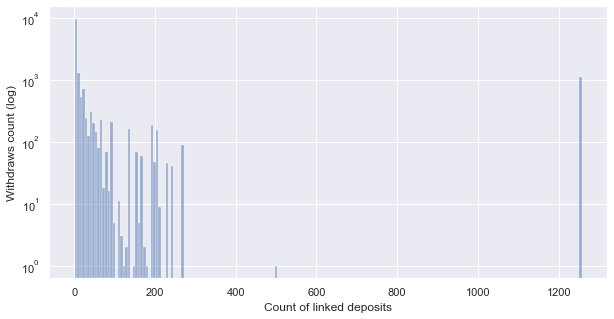

In [36]:
linked_deposits_counts = {}
for key in w2d.keys():
    linked_deposits_counts[key] = len(w2d[key])

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.histplot(linked_deposits_counts.values(), bins=200, legend=False)
plt.xlabel("Count of linked deposits")
plt.ylabel("Withdraws count (log)")
plt.yscale("log")

In [37]:
def number_of_linked_withdraw_addresses(w2d_dict: dict) -> int:
    l = []
    for key in w2d_dict.keys():
        l.append(w2addr[key])
    return len(set(l))

In [38]:
w2addr = w2add(withdraw_txs)
d2addr = d2add(deposit_txs)

83782it [00:00, 250694.98it/s]
97365it [00:00, 231980.46it/s]


---
#### How many withdrawal addresses can be linked to deposit addresses?

In [39]:
print(f"Withdrawal addresses that can be linked to deposit addresses: {number_of_linked_withdraw_addresses(w2d)}")

Withdrawal addresses that can be linked to deposit addresses: 4620


#### How many withdrawal transactions can be linked to deposit transactions?

In [40]:
print(f"Withdrawal transactions that can be linked to deposit transactions: {len(w2d)}")

Withdrawal transactions that can be linked to deposit transactions: 15693


In [41]:
# Auxiliary function
# Return all the withdrawals the input address has done.
def get_address_withdraws(address, withdraw_txs):
    return withdraw_txs[withdraw_txs["recipient_address"] == address ].hash

In [42]:
'''
Initialize the address_map, that will follow the next structure
{'withdrawal address': [[withdrawals made],[compromised deposit transactions]], ... }
Definitions:
withdrawals made: The Tcash withdrawals made by the 'withdrawal address'
compromised deposit transactions: The compromised deposit transactions of the 'withdrawals made'.
'''

address_map = {}
for address in unique_withdraw_addresses:
    address_map[address] = [[],[]]

for address in unique_withdraw_addresses:
    deposit = {}
    address_transactions = get_address_withdraws(address, withdraw_txs)
    address_map[address][0] = address_transactions
    for row in address_transactions:
        address_map[address][1] +=  w2d.get(row,[])

In [43]:
'''
Since we want to plot the points (number of withdrawals, number compromised deposit transactions) 
of each withdrawal address,
we need to remove the duplicated compromised deposit transactions and
get the cardinal of each set.

We end up with a dictionary,
{withdrawal address: (number of withdrawals, number compromised deposit transactions), ...}
'''

scatter_points = {}
for (address, value) in address_map.items():
    scatter_points[address] = (len(set(value[0])), len(set(value[1])))

Text(0.5, 1.0, 'Number of withdraws and deposits for each address')

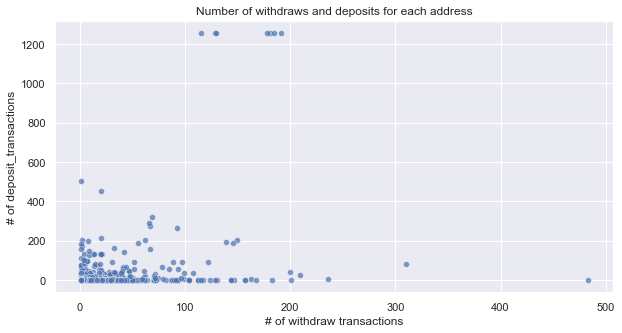

In [44]:
x = [x[0] for x in scatter_points.values()]
y = [x[1] for x in scatter_points.values()]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x=x,y=y, alpha=0.7)
plt.xlabel("# of withdraw transactions")
plt.ylabel("# of deposit_transactions")
plt.title("Number of withdraws and deposits for each address")

#### Number of compromised deposits

In [45]:
compromised_deposits = set([compromised_deposit for value in address_map.values() for compromised_deposit in value[1]])

In [46]:
len(compromised_deposits)

18998

In [47]:
print(f"Number of compromised deposits: {len(compromised_deposits)}")

Number of compromised deposits: 18998


Average number of compromised deposits per linked withdrawal address

In [48]:
number_of_compromised_deposits =  [value[1] for value in scatter_points.values() if value[1] != 0]

Text(0.5, 1.0, 'Histogram of compromised deposits per linked withdrawal address')

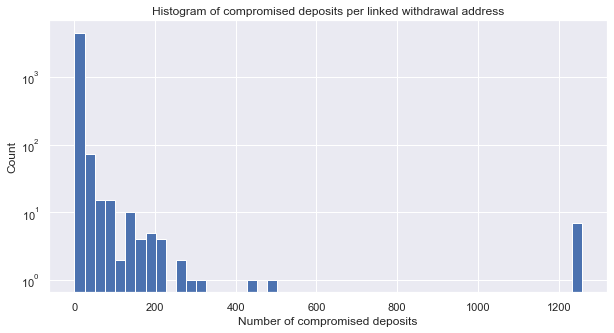

In [49]:
plt.figure(figsize=(10, 5))
plt.hist(number_of_compromised_deposits, bins=50)
plt.yscale("log")
plt.xlabel("Number of compromised deposits")
plt.ylabel("Count")
plt.title("Histogram of compromised deposits per linked withdrawal address")

In [50]:
print(f"Average number of compromised deposits per linked withdrawal address: {sum(number_of_compromised_deposits)/ len(number_of_compromised_deposits)}") 

Average number of compromised deposits per linked withdrawal address: 7.294155844155844


#### Compromised deposit transactions for each TCash pool

In [51]:
def tx_to_pool(txs_df):
    tx_to_pool_dict = {}
    for row in tqdm(txs_df.itertuples(), mininterval=1):
        tx_to_pool_dict[row.hash] = row.tcash_pool
    
    return tx_to_pool_dict

In [52]:
tx_to_pool_dict = tx_to_pool(deposit_txs)
compromised_deposit_hashes = set(list(itertools.chain(*w2d.values())))
number_of_compromised_deposits_by_pool = Counter(list(map(lambda x: tx_to_pool_dict[x], compromised_deposit_hashes)))

97365it [00:00, 202335.81it/s]


In [53]:
pools_to_deposits = dict(deposit_txs.groupby("tcash_pool")["hash"].apply(list))
number_of_uncompromised_deposits_by_pool = {}
for pool in list(pools_to_deposits.keys()):
    number_of_uncompromised_deposits_by_pool[pool] = len(pools_to_deposits[pool]) - number_of_compromised_deposits_by_pool[pool]

In [54]:
compromised_vs_uncompromised_by_pool = {}

for pool in list(number_of_compromised_deposits_by_pool.keys()):
    compromised_vs_uncompromised_by_pool[pool] = (number_of_compromised_deposits_by_pool[pool], number_of_uncompromised_deposits_by_pool[pool])

In [55]:
eth_pools = ["0.1 ETH", "1 ETH", "10 ETH", "100 ETH"]
tkn_pools = [pool for pool in compromised_vs_uncompromised_by_pool.keys() if pool not in eth_pools]
all_pools = eth_pools + tkn_pools

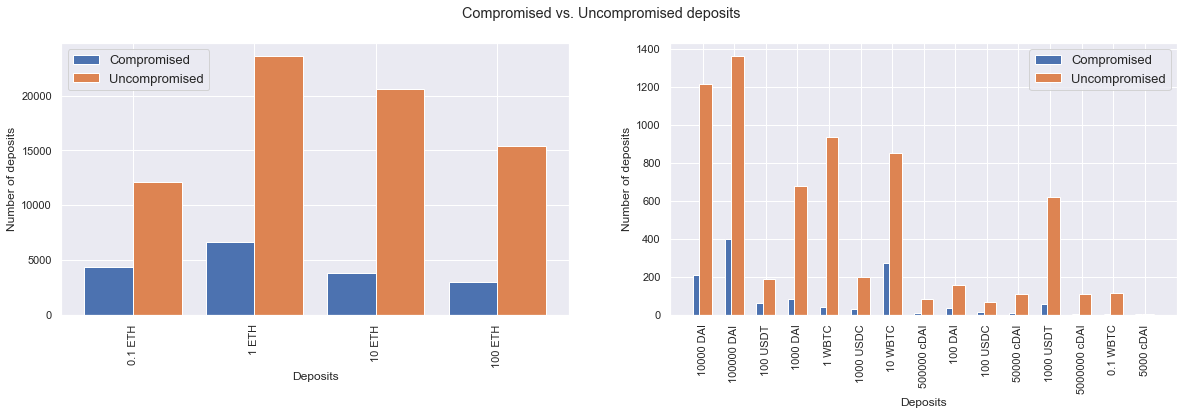

In [56]:
points = [compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in points[:4]]
eth_uncompromised = [t[1] for t in points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in points[4:]]
tkn_uncompromised = [t[1] for t in points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))

sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncompromised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Deposits")
ax1.set_ylabel("Number of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Deposits")
ax2.set_ylabel("Number of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposits")

plt.show()

In [57]:
rate_compromised_vs_uncompromised_by_pool = {}
for pool in compromised_vs_uncompromised_by_pool.keys():
    n_compromised = compromised_vs_uncompromised_by_pool[pool][0]
    n_uncompromised = compromised_vs_uncompromised_by_pool[pool][1]
    total_deposits = n_compromised + n_uncompromised
    
    rate_compromised_vs_uncompromised_by_pool[pool] = (n_compromised/total_deposits * 100, n_uncompromised/total_deposits * 100)

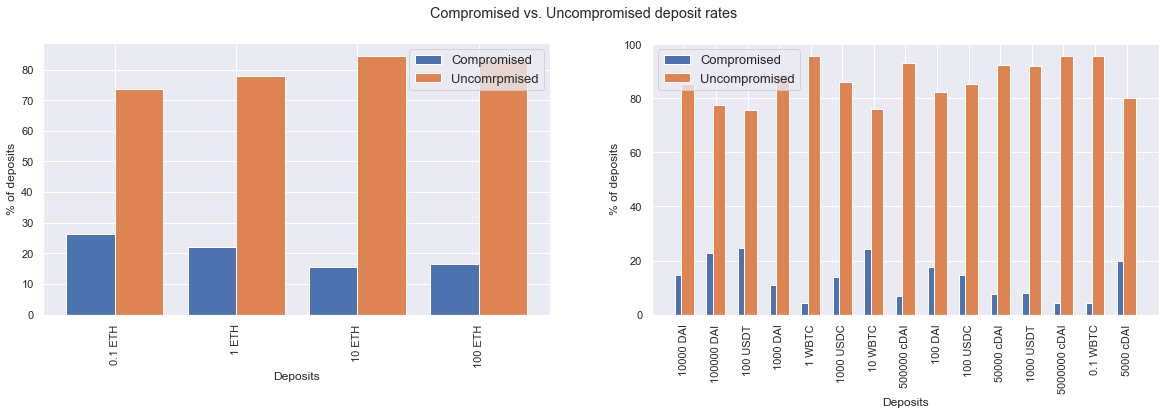

In [58]:
rate_points = [rate_compromised_vs_uncompromised_by_pool[pool] for pool in all_pools]

eth_compromised = [t[0] for t in rate_points[:4]]
eth_uncompromised = [t[1] for t in rate_points[:4]]
eth_x_axis = np.arange(len(eth_pools))

tkn_compromised = [t[0] for t in rate_points[4:]]
tkn_uncompromised = [t[1] for t in rate_points[4:]]
tkn_x_axis = np.arange(len(tkn_pools))


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
ax1.bar(eth_x_axis - 0.2, eth_compromised, 0.4, label = "Compromised")
ax1.bar(eth_x_axis + 0.2, eth_uncompromised, 0.4, label = "Uncomrpmised")
ax1.set_xticks(eth_x_axis)
ax1.set_xticklabels(eth_pools, rotation="vertical")
ax1.set_xlabel("Deposits")
ax1.set_ylabel("% of deposits")
ax1.legend(fontsize=13)

ax2.bar(tkn_x_axis - 0.1, tkn_compromised, 0.4, label = "Compromised")
ax2.bar(tkn_x_axis + 0.1, tkn_uncompromised, 0.4, label = "Uncompromised")
ax2.set_xticks(tkn_x_axis)
ax2.set_xticklabels(tkn_pools, rotation="vertical")
ax2.set_xlabel("Deposits")
ax2.set_ylabel("% of deposits")
ax2.legend(fontsize=13)
fig.suptitle("Compromised vs. Uncompromised deposit rates")

plt.show()

In [59]:
txs = np.empty((len(address_and_withdraw_df)), dtype=set)
for i, row in enumerate(address_and_withdraw_df.itertuples()):
    txs[i] = frozenset([row.from_address, row.to_address])

txs = list(filter(lambda x: len(x) == 2, txs))
recurrent_interactions = list(Counter(txs).values())

Text(0.5, 1.0, 'Histogram of transactions between heuristically linked deposit and withdraw addresses outisde TCash')

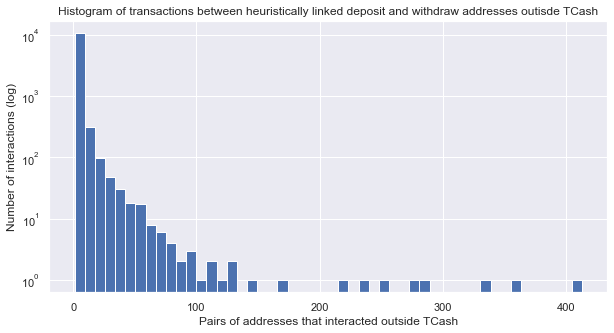

In [60]:
plt.figure(figsize=(10, 5))
plt.hist(recurrent_interactions, bins=50)
plt.yscale("log")
plt.xlabel("Pairs of addresses that interacted outside TCash")
plt.ylabel("Number of interactions (log)")
plt.title("Histogram of transactions between heuristically linked deposit and withdraw addresses outisde TCash")

## Heuristic 4 

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [61]:
withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")

In [62]:
tornado_addresses = {
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3": "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144": "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730": "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334": "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc": "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936": "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf": "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291": "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307": "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d": "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b": "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f": "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1": "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4": "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498": "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b": "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003": "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701": "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af": "5000000 cDAI"
}

In [63]:
withdraw_transactions_df

,Unnamed: 0,Unnamed: 0.1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,...,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
0,0,7,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb...,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,...,1,2020-10-05 07:57:28 UTC,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be9...,NaN,NaN,NaN,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
1,1,8,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da...,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,...,1,2020-02-11 19:10:54 UTC,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac06...,NaN,NaN,NaN,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
2,2,9,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f...,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,...,1,2020-02-16 16:05:14 UTC,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290...,NaN,NaN,NaN,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
3,3,13,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad1...,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,...,1,2020-11-09 17:08:00 UTC,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaee...,NaN,NaN,NaN,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
4,4,15,0x30becee80e63a039102df3b1243e5d314534abfcf3ed...,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,...,1,2020-11-29 01:18:57 UTC,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e...,NaN,NaN,NaN,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83777,83777,181253,0x5a36df89fa1f1ef6de7254e4b5fbfd2d6c2297ef4621...,164,188,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570447,70188284576,...,1,2021-09-05 01:23:28 UTC,13162729,0xe14fb1085bc975af1ad751aa579d7de298fb5be86c3d...,1.027888e+11,2.210156e+09,2.0,70188284576,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47
83778,83778,181255,0x43a081968e109f71a2f807f4a94ffc77429b322c3c1e...,169,168,0xe7a784acb145bd8993e83d41adf43b7c7195e995,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567923,39255417592,...,1,2021-10-03 14:49:29 UTC,13346858,0xe5a4d9c829998f00873f6ac4603174d707ffb2ea79a3...,4.000000e+10,1.130179e+09,2.0,39255417592,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xe7a784acb145bd8993e83d41adf43b7c7195e995
83779,83779,181262,0xd0708b3e2135d0378a9d6fe3fdc58b3c4fbcbcbe926c...,246,10,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,567971,50193886615,...,1,2021-10-17 23:36:24 UTC,13438417,0x36808310975d158e0f2b3a2f892abed25a955684f407...,7.518635e+10,1.519911e+09,2.0,50193886615,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xa85f4669b31ad9c75adbfd288c37b678ab0b0fa4
83780,83780,181263,0x54b5ceca9fd3d2ff7893c32f901f3d1d5e2e4383607b...,127,180,0xd2ddee09e723d165233986e0ed0aa6da1cea97e0,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,570459,81048817558,...,1,2021-09-04 22:53:33 UTC,13162025,0x15a807c50ecea90cd58f5f9d6a26e0c60f3e9f06dfa6...,1.349098e+11,3.899014e+09,2.0,81048817558,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x107753c195edde2fe69e573f667a697526178a47


### Function summary: compare_transactions

Given two dictionaries, withdraw_dict and deposit_dict representing the total deposits and withdraws made by an address to each TCash pool, respectively, compares if the set of keys of both are equal and when they are, checks if all values in the deposit dictionary are equal or greater than each of the corresponding values of the withdraw dicionary. If this is the case, returns $True$, if not, $False$.

In [64]:
def compare_transactions(withdraw_dict, deposit_dict):
    if set(withdraw_dict.keys()) != set(deposit_dict.keys()):
        return False
    for currency in withdraw_dict.keys():
        if not (deposit_dict[currency] >= withdraw_dict[currency]):
            return False
    return True

### Function summary: get_number_of_withdraws

Given a particular withdraw transaction and the withdraw transactions DataFrame, gets the total withdraws the address made in each pool. It is returned as a dictionary with the pools as the keys and the number of withdraws as the values.

In [65]:
def get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses):
    
    n_withdraws = {tornado_addresses[withdraw_transaction.tornado_cash_address]: 1}
    
    for withdraw_row in withdraw_transactions_df.itertuples():
        if (withdraw_row.recipient_address == withdraw_transaction.recipient_address) and (withdraw_row.block_timestamp <= withdraw_transaction.block_timestamp) and (withdraw_row.hash != withdraw_transaction.hash):
            if tornado_addresses[withdraw_row.tornado_cash_address] in n_withdraws.keys():
                n_withdraws[tornado_addresses[withdraw_row.tornado_cash_address]] += 1
            else:
                n_withdraws[tornado_addresses[withdraw_row.tornado_cash_address]] = 1
    return n_withdraws

### Function summary: get_address_deposits

Given the deposit transactions DataFrame, returns a dictionary with every address of the deposit

In [66]:
def get_address_deposits(deposit_transactions_df, tornado_addresses):
    
    addresses_and_deposits_counts = pd.DataFrame(deposit_transactions_df[["from_address", "tornado_cash_address"]].value_counts()).rename(columns={0:"count"})
    
    addresses_and_deposits_dict = {}
    for row in addresses_and_deposits_counts.itertuples():
        if row.Index[0] in addresses_and_deposits_dict.keys():
            addresses_and_deposits_dict[row.Index[0]][tornado_addresses[row.Index[1]]] = row.count
        else:
            addresses_and_deposits_dict[row.Index[0]] = {tornado_addresses[row.Index[1]]: row.count}
            
    return addresses_and_deposits_dict

In [67]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
address_deposits

{'0x16e54b35d789832440ab47ae765e6a8098280676': {'0.1 ETH': 1068,
  '100 USDT': 1},
 '0x35dd029618f4e1835008da21fd98850c776453f0': {'0.1 ETH': 628},
 '0xe906442c11b85acbc58eccb253b9a55a20b80a56': {'0.1 ETH': 562},
 '0xaf301de836c81deb8dff9dc22745e23c476155b2': {'1 ETH': 503,
  '0.1 ETH': 96,
  '10 ETH': 8},
 '0xdc4dcbc3f199a8b6ba51bdfd9db46051ab88a2f7': {'1 ETH': 395},
 '0xb9d8ee59a0e5f908d3a87b8b272593761b40f298': {'1 ETH': 296},
 '0xd88189f7dee6e5dbd6cbc6f06fd357f4bf7f330b': {'100 ETH': 282, '10 WBTC': 80},
 '0x30030383d959675ec884e7ec88f05ee0f186cc06': {'100 ETH': 282},
 '0xe0e484dfa7f3aa36733a915d6f07eb5a57a74a11': {'100 ETH': 264,
  '100000 DAI': 50},
 '0x592c67dc41f6e5a7a39a836b031beb555cbef2f5': {'1 ETH': 251},
 '0x5386bb30475c4f6aac993faac62c3093ca0ac26d': {'1 ETH': 251},
 '0x6a1cf24c645db2e37141fa12e70cb67e56b336f3': {'0.1 ETH': 204, '10 ETH': 1},
 '0x0ad942b82c46cd22f4936ca7011e3a3c57755707': {'1 ETH': 202},
 '0xda8774d99fba48cfa13344285259401d93304a60': {'1 WBTC': 200},
 '0xa

In [68]:
get_number_of_withdraws(withdraw_transactions_df.iloc[2], withdraw_transactions_df, tornado_addresses)

{'1000 USDC': 2, '100 ETH': 1, '0.1 ETH': 1}

In [69]:
d = {'1 ETH': 93,
  '100 ETH': 4,
  '1 WBTC': 3,
  '0.1 ETH': 1,
  '0.1 WBTC': 1}

### Function summary: get_same_or_more_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same or more number of deposits. Returns an array with all the addresses that match these requirements.

In [70]:
def get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses):
    
    return list(dict(filter(lambda elem: compare_transactions(n_withdraws, elem[1]), address_deposits.items())).keys())

In [71]:
get_same_or_more_number_of_deposits(d, address_deposits, tornado_addresses)

['0x6e8df51931f8675cf7e12447e1fe25b26c8775c7']

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [72]:
def same_number_of_deposits_heuristic(withdraw_transaction, address_deposits, withdraw_transactions_df, tornado_addresses):
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)

    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    C = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    try:
        return 1 - 1/len(C)
    except:
        return 1

In [73]:
def apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses):
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    tx_hash_and_anonimity_score = {}
    
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total = withdraw_transactions_df.shape[0], mininterval=5):
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, address_deposits, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score

    return tx_hash_and_anonimity_score

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [ ]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)

  0%|                                   | 104/83782 [00:36<8:22:47,  2.77it/s]

In [ ]:
scores

In [ ]:
plt.hist(scores.values(), bins=100, density=True)
plt.title("Histogram of scores of the withdrawal transactions")
plt.xlabel("Scores")
plt.show()